## Download Dataset

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/NMT
!pip install transformers
import pathlib
import pickle
import random
import re
import unicodedata
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [ ]:
import pathlib
import tensorflow as tf

text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent/"fra.txt"
print(text_file)

3423204/3423204 [==============================] - 0s 0us/step
/root/.keras/datasets/fra.txt


## Preprocessing

In [ ]:
import pathlib
import pickle
import random
import re
import unicodedata

def normalize(line):
    """
    Normalize a line of text and split into two at the tab character
    Args: The normalize function takes a line of text as input.
    Return: Normalized English and French sentences as a tuple (eng, fra).
    """
    line = unicodedata.normalize("NFKC", line.strip())

    # Perform regular expression substitutions to add spaces around non-alphanumeric characters
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)

    # Split the line of text into two parts at the tab character
    eng, fra = line.split("\t")

    # Add "[start]" and "[end]" tokens to the "fra" part of the line
    fra = "[start] " + fra + " [end]"

    # Return the normalized English and French sentences
    return eng, fra


# normalize each line and separate into English and French
with open(text_file) as fp:
    text_pairs = [normalize(line) for line in fp]

print(f"Each sample of data will look like this: {text_pairs[55805]}")
print(f"Numper of sampels: {len(text_pairs)}")
print(f"Max length in english sequences: {max([len(x[0].split()) for x in text_pairs])}")
print(f"Max length in french sequences: {max([len(x[1].split()) for x in text_pairs])}")
print(f"Numper of token in english sequences: {len(set(token for s in [x[0].split() for x in text_pairs] for token in s))}")
print(f"Numper of token in french sequences: {len(set(token for s in [x[1].split() for x in text_pairs] for token in s))}")

Each sample of data will look like this: ('What does he see in her ?', '[start] Que lui trouve-t-il  ?  [end]')
Numper of sampels: 167130
Max length in english sequences: 51
Max length in french sequences: 60
Numper of token in english sequences: 16721
Numper of token in french sequences: 31405


In [ ]:
random.shuffle(text_pairs)
max_len = max([max([len(x[0].split()), len(x[1].split())]) for x in text_pairs])
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{max_len} maximum length")
print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

60 maximum length
167130 total pairs
116992 training pairs
25069 validation pairs
25069 test pairs



## Vectorization and Making Datasets

In [ ]:
from tensorflow.keras.layers import TextVectorization

class Config:
    def __init__(self):
        self.sequence_length = 60
        self.source_vocab_size = 14969
        self.target_vocab_size = 29219

config = Config()

# English layer
eng_vectorizer = TextVectorization(
    max_tokens=config.source_vocab_size,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=config.sequence_length,
)
# French layer
fra_vectorizer = TextVectorization(
    max_tokens=config.target_vocab_size,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=config.sequence_length + 1 # since we'll need to offset the sentence by one step during training.

)

train_eng_texts = [pair[0] for pair in train_pairs]
train_fra_texts = [pair[1] for pair in train_pairs]

# Learn the vocabulary
eng_vectorizer.adapt(train_eng_texts)
fra_vectorizer.adapt(train_fra_texts)

In [ ]:
# save for subsequent steps
with open("vectorize.pickle", "wb") as fp:
    data = {
        "train": train_pairs,
        "val":   val_pairs,
        "test":  test_pairs,
        "engvec_config":  eng_vectorizer.get_config(),
        "engvec_weights": eng_vectorizer.get_weights(),
        "fravec_config":  fra_vectorizer.get_config(),
        "fravec_weights": fra_vectorizer.get_weights(),
    }
    pickle.dump(data, fp)

In [ ]:
with open("vectorize.pickle", "rb") as fp:
    data = pickle.load(fp)

train_pairs = data["train"]
val_pairs = data["val"]
test_pairs = data["test"]   # not used
eng_vectorizer = TextVectorization.from_config(data["engvec_config"])
eng_vectorizer.set_weights(data["engvec_weights"])
fra_vectorizer = TextVectorization.from_config(data["fravec_config"])
fra_vectorizer.set_weights(data["fravec_weights"])

In [ ]:
from tensorflow.data import AUTOTUNE

def format_dataset(eng, fra):
    """
    Formats the dataset by applying vectorization and preparing the inputs for the encoder and decoder.

    Args:
        eng: English text tensor.
        fra: French text tensor.

    Returns:
        Tuple of formatted inputs for the encoder and decoder.
    """
    eng = eng_vectorizer(eng)
    fra = fra_vectorizer(fra)
    return (
        {"encoder_inputs": eng, "decoder_inputs": fra[:, :-1]},
        fra[:, 1:]
    )


def make_dataset(pairs, batch_size=64):
    """
    Creates a dataset from pairs of English and French texts.

    Args:
        pairs: List of pairs containing English and French texts.
        batch_size: Batch size for the dataset.

    Returns:
        Formatted and preprocessed dataset.
    """
    eng_texts, fra_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    fra_texts = list(fra_texts)

    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fra_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(2048).prefetch(tf.data.experimental.AUTOTUNE).cache()

    return dataset

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

## Transformer Building Blocks

### Embeddings

#### Sinu_embeddings

In [ ]:
import tensorflow as tf

class SinusoidalPositionalEncoding(tf.keras.layers.Layer):
    """
    SinusoidalPositionalEncoding layer.

    This layer applies sinusoidal positional encodings to the input embeddings.

    Args:
        config (object): Configuration object containing parameters.
    """
    def __init__(self, config, name = None, **kwargs):
        """
        Initialize the SinusoidalPositionalEncoding layer.

        Args:
            config (object): Configuration object with parameters for positional encoding.
        """
        super(SinusoidalPositionalEncoding, self).__init__(name = name)
        super(SinusoidalPositionalEncoding, self).__init__(**kwargs)

    def call(self, input_ids):
        """
        Apply positional encodings to the input embeddings.

        Args:
            input_ids (tf.Tensor): Input tensor containing token IDs.

        Returns:
            tf.Tensor: Output tensor with positional encodings added.
        """
        self.position_encoding = self.create_positional_encoding_matrix(
                input_ids.shape[1], config.hidden_size, config.frequency_factor
        )
        return self.position_encoding

    def create_positional_encoding_matrix(self, sequence_length, embedding_dimension, frequency_factor=10000):
        """
        Create a positional encoding matrix.

        Args:
            sequence_length (int): Length of the input sequence.
            embedding_dimension (int): Dimensionality of the positional embeddings. Must be an even integer.
            frequency_factor (int): Constant for the sinusoidal functions.

        Returns:
            tf.Tensor: Matrix of positional embeddings of shape (sequence_length, embedding_dimension).
            The value at element (k, 2i) is sin(k / frequency_factor^(2i / embedding_dimension)),
            and the value at element (k, 2i+1) is cos(k / frequency_factor^(2i / embedding_dimension)).
        """
        assert embedding_dimension % 2 == 0, "Embedding dimension needs to be an even integer"
        embedding_dimension_half = embedding_dimension // 2
        positions = tf.range(sequence_length, dtype=tf.float32)[:, tf.newaxis]  # Column vector of shape (sequence_length, 1)
        frequency_indices = tf.range(embedding_dimension_half, dtype=tf.float32)[tf.newaxis, :]  # Row vector of shape (1, embedding_dimension/2)
        frequency_denominator = tf.pow(frequency_factor, -frequency_indices / embedding_dimension_half)  # frequency_factor^(-2i/d)
        frequency_arguments = positions / frequency_denominator  # Matrix of shape (sequence_length, embedding_dimension)
        sin_values = tf.sin(frequency_arguments)
        cos_values = tf.cos(frequency_arguments)
        positional_encodings = tf.concat([sin_values, cos_values], axis=1)

        return positional_encodings

    def get_config(self):
        """
        Get the configuration of the SinusoidalPositionalEncoding layer.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config()
        return config

In [ ]:
# Define the configuration
class Config:
    def __init__(self):
        self.sequence_length = 4
        self.source_vocab_size = 14969
        self.target_vocab_size = 29219
        self.hidden_size = 4
        self.frequency_factor = 10000
        self.mask_zero = True

config = Config()

# Create an instance of the SinusoidalPositionalEncoding layer
positional_encoding_layer = SinusoidalPositionalEncoding(config)

# Create a sample input tensor with token IDs
batch_size = 1
seq_length = 4
input_ids = tf.random.uniform((batch_size, seq_length), maxval=config.sequence_length, dtype=tf.int32)

# Apply positional encodings
output_embeddings = positional_encoding_layer(input_ids)

# Print the output positional embeddings
print("Outputs:")
print(input_ids)
print(output_embeddings)

Outputs:
tf.Tensor([[3 2 2 3]], shape=(1, 4), dtype=int32)
tf.Tensor(
[[ 0.          0.          1.          1.        ]
 [ 0.841471   -0.5063722   0.5403023   0.862315  ]
 [ 0.90929747 -0.8733047  -0.4161468   0.48717433]
 [ 0.14112    -0.99975514 -0.9899925  -0.02212713]], shape=(4, 4), dtype=float32)


#### Pos_Embeddings

In [ ]:
import tensorflow as tf

class PositionalEmbeddings(tf.keras.layers.Layer):
    """
    PositionalEmbeddings layer.

    This layer generates positional embeddings based on input IDs.
    It uses an Embedding layer to map position IDs to position embeddings.

    Args:
        config (object): Configuration object containing parameters.
    """

    def __init__(self, config, name = None, **kwargs):
        super(PositionalEmbeddings, self).__init__(name = name)
        super(PositionalEmbeddings, self).__init__(**kwargs)
        self.positional_embeddings = tf.keras.layers.Embedding(
            input_dim=config.sequence_length, output_dim=config.hidden_size
        )

    def call(self, input_ids):
        """
        Generate positional embeddings.

        Args:
            input_ids (tf.Tensor): Input tensor containing token IDs.

        Returns:
            tf.Tensor: Positional embeddings tensor of shape (batch_size, seq_length, hidden_size).
        """
        seq_length = input_ids.shape[1]
        position_ids = tf.range(seq_length, dtype=tf.int32)[tf.newaxis, :]
        position_embeddings = self.positional_embeddings(position_ids)
        return position_embeddings

    def get_config(self):
        """
        Get the layer configuration.

        Returns:
            dict: Dictionary containing the layer configuration.
        """
        config = super().get_config()
        config.update({
            "positional_embeddings": self.positional_embeddings,
        })
        return config

In [ ]:
# Define the configuration
class Config:
    def __init__(self):
        self.sequence_length = 4
        self.source_vocab_size = 14969
        self.target_vocab_size = 29219
        self.hidden_size = 4
        self.frequency_factor = 10000
        self.max_position_embeddings = 4
        self.mask_zero = True

config = Config()

# Create an instance of the PositionalEmbeddings layer
positional_encoding_layer = PositionalEmbeddings(config)

# Create a sample input tensor with token IDs
batch_size = 1
seq_length = 4
input_ids = tf.random.uniform((batch_size, seq_length), maxval=config.sequence_length, dtype=tf.int32)

# Apply positional encodings
output_embeddings = positional_encoding_layer(input_ids)

# Print the output positional embeddings
print("Outputs:")
print(output_embeddings)


Outputs:
tf.Tensor(
[[[ 0.01630845 -0.0280382  -0.01342707  0.00249801]
  [ 0.01012968 -0.00064945 -0.02948507  0.02167038]
  [-0.04061853  0.03396517  0.02463391 -0.00579173]
  [-0.01580817 -0.03685774 -0.01101297  0.0341831 ]]], shape=(1, 4, 4), dtype=float32)


#### Embeddings layer

In [ ]:
import tensorflow as tf

class Embeddings(tf.keras.layers.Layer):
    """
    Embeddings layer.

    This layer combines token embeddings with positional embeddings to create the final embeddings.

    Args:
        config (object): Configuration object containing parameters.
        vocab_size: Vocabulary size.

    Attributes:
        token_embeddings (tf.keras.layers.Embedding): Token embedding layer.
        PositionalInfo (tf.keras.layers.Layer): Positional information layer.
        dropout (tf.keras.layers.Dropout): Dropout layer for regularization.
        norm (tf.keras.layers.LayerNormalization): Layer normalization for normalization.
    """

    def __init__(self, config, vocab_size, name = None,  **kwargs):
        super(Embeddings, self).__init__(name = name)
        super(Embeddings, self).__init__(**kwargs)
        self.token_embeddings = tf.keras.layers.Embedding(
            input_dim= vocab_size, output_dim=config.hidden_size
        )
        if config.positional_information_type == 'embs':
            self.PositionalInfo = PositionalEmbeddings(config)
        elif config.positional_information_type == 'sinu':
            self.PositionalInfo = SinusoidalPositionalEncoding(config)

        self.dropout = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.norm = tf.keras.layers.LayerNormalization()

    def call(self, input_ids, training=False):
        """
        Generate embeddings for input IDs.

        Args:
            input_ids (tf.Tensor): Input tensor containing token IDs.
            training (bool, optional): Whether the model is in training mode. Defaults to False.

        Returns:
            tf.Tensor: Embeddings tensor of shape (batch_size, seq_length, hidden_size).
        """
        positional_info = self.PositionalInfo(input_ids)
        x = self.token_embeddings(input_ids)
        x += positional_info
        x = self.norm(x)
        x = self.dropout(x, training=training)
        return x

    def compute_mask(self, inputs, mask=None):
        """
        Computes the mask for the inputs.

        Args:
            inputs (tf.Tensor): Input tensor.
            mask (tf.Tensor, optional): Mask tensor. Defaults to None.

        Returns:
            tf.Tensor: Computed mask tensor.
        """
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        """
        Get the layer configuration.

        Returns:
            dict: Dictionary containing the layer configuration.
        """
        config = super().get_config()
        config.update({
            "token_embeddings": self.token_embeddings,
            "PositionalInfo": self.PositionalInfo,
            "dropout": self.dropout,
            "norm": self.norm,
        })
        return config

In [ ]:
# Define the configuration
class Config:
    def __init__(self):
        self.sequence_length = 4
        self.source_vocab_size = 14969
        self.target_vocab_size = 29219
        self.hidden_size = 4
        self.frequency_factor = 10000
        self.max_position_embeddings = 4
        self.positional_information_type = 'embs'
        self.source_vocab_size = 10
        self.target_vocab_size = 10
        self.hidden_dropout_prob = 0.1


config = Config()

# Create an instance of the Embeddings layer
Embeddings_layer = Embeddings(config, vocab_size = 10)

# Create a sample input tensor with token IDs
batch_size = 1
seq_length = 4
input_ids = tf.random.uniform((batch_size, seq_length), maxval=config.sequence_length, dtype=tf.int32)

# Apply positional encodings
output_embeddings = Embeddings_layer(input_ids)

# Print the output positional embeddings
print("Outputs:")
print(output_embeddings)

### Encoder

#### Attination Head

In [ ]:
class AttentionHead(tf.keras.layers.Layer):
    """
    Attention head implementation.

    Args:
        head_dim: Dimensionality of the attention head.

    Attributes:
        head_dim: Dimensionality of the attention head.
        query_weights: Dense layer for query projection.
        key_weights: Dense layer for key projection.
        value_weights: Dense layer for value projection.
    """

    def __init__(self, head_dim, name = None, **kwargs):
        super(AttentionHead, self).__init__(name = name)
        super(AttentionHead, self).__init__(**kwargs)
        self.supports_masking = True  # Enable masking support
        self.head_dim = head_dim
        self.query_weights = tf.keras.layers.Dense(head_dim)
        self.key_weights = tf.keras.layers.Dense(head_dim)
        self.value_weights = tf.keras.layers.Dense(head_dim)

    def call(self, query, key, value, mask=None):
        """
        Applies attention mechanism to the input query, key, and value tensors.

        Args:
            query: Query tensor.
            key: Key tensor.
            value: Value tensor.
            mask: Optional mask tensor.

        Returns:
            Updated value embeddings after applying attention mechanism.
        """
        query = self.query_weights(query)
        key = self.key_weights(key)
        value = self.value_weights(value)

        att_scores = tf.matmul(query, tf.transpose(key, perm=[0, 2, 1])) / tf.math.sqrt(tf.cast(tf.shape(query)[-1], tf.float32))

        if mask is not None:
            mask = tf.cast(mask, dtype=tf.bool)
            att_scores = tf.where(mask, att_scores, tf.constant(-1e9, dtype=att_scores.dtype))

        att_weights = tf.nn.softmax(att_scores, axis=-1)
        n_value = tf.matmul(att_weights, value)

        return n_value

    def get_config(self):
        """
        Returns the configuration of the attention head layer.

        Returns:
            Configuration dictionary.
        """
        config = super().get_config()
        config.update({
            "head_dim": self.head_dim,
            "query_weights": self.query_weights,
            "key_weights": self.key_weights,
            "value_weights": self.value_weights,
        })
        return config


#### Multi-head attention

In [ ]:
class MultiHead_Attention(tf.keras.layers.Layer):
    """
    Multi-head attention layer implementation.

    Args:
        config: Configuration object containing hyperparameters.

    Attributes:
        supports_masking: Boolean indicating if the layer supports masking.
        hidden_size: Dimensionality of the hidden state.
        num_heads: Number of attention heads.
        head_dim: Dimensionality of each attention head.
        attention_heads: List of AttentionHead layers.
        fc: Fully connected layer for final projection.
    """

    def __init__(self, config, name=None, **kwargs):
        super(MultiHead_Attention, self).__init__(name=name)
        super(MultiHead_Attention, self).__init__(**kwargs)
        self.supports_masking = True
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_heads
        self.head_dim = config.hidden_size // config.num_heads
        self.attention_heads = [AttentionHead(self.head_dim) for _ in range(self.num_heads)]
        self.fc = tf.keras.layers.Dense(config.hidden_size)

    def call(self, query, key, value, mask=None):
        """
        Applies multi-head attention mechanism to the input query, key, and value tensors.

        Args:
            query: Query tensor.
            key: Key tensor.
            value: Value tensor.
            mask: Optional mask tensor.

        Returns:
            Updated hidden state after applying multi-head attention mechanism.
        """
        attention_outputs = [attention_head(query, key, value, mask=mask) for attention_head in self.attention_heads]
        hidden_state = tf.concat(attention_outputs, axis=-1)
        hidden_state = self.fc(hidden_state)
        return hidden_state

    def get_config(self):
        """
        Returns the configuration of the multi-head attention layer.

        Returns:
            Configuration dictionary.
        """
        config = super().get_config()
        config.update({
            "hidden_size": self.hidden_size,
            "num_heads": self.num_heads,
            "head_dim": self.head_dim,
            "attention_heads": self.attention_heads,
            "fc": self.fc,
        })
        return config

In [ ]:
# Define the configuration
class Config:
    def __init__(self):
        self.sequence_length = 4
        self.source_vocab_size = 10
        self.target_vocab_size = 10
        self.hidden_size = 4
        self.frequency_factor = 10000
        self.max_position_embeddings = 4
        self.positional_information_type = 'embs'
        self.hidden_dropout_prob = 0.1
        self.num_heads = 2

config = Config()

Embeddings_layer = Embeddings(config, 10)

input_ids = tf.constant([[2, 2, 0, 0]])

x = Embeddings_layer(input_ids)

# Apply MultiHeadAttention
multihead_attn = MultiHead_Attention(config)
x = multihead_attn(x, x, x)

print("Outputs:")
print(x)

Outputs:
tf.Tensor(
[[[-0.19603872  0.62370175  0.00938863 -0.8792861 ]
  [-0.19392842  0.6028574   0.00985217 -0.895087  ]
  [-0.19179727  0.6012584   0.0114027  -0.89725673]
  [-0.19112027  0.59981096  0.01184295 -0.89861196]]], shape=(1, 4, 4), dtype=float32)


#### The Feed-Forward Layer and Normalization

In [ ]:
class FeedForward(tf.keras.layers.Layer):
    """
    Feed-forward layer implementation.

    Args:
        config: Configuration object containing hyperparameters.

    Attributes:
        supports_masking: Boolean indicating if the layer supports masking.
        fc1: First dense layer.
        fc2: Second dense layer.
        dropout: Dropout layer.
    """

    def __init__(self, config, name=None, **kwargs):
        super(FeedForward, self).__init__(name=name)
        super(FeedForward, self).__init__(**kwargs)
        self.supports_masking = True
        self.fc1 = tf.keras.layers.Dense(config.intermediate_fc_size, activation=tf.keras.activations.gelu)
        self.fc2 = tf.keras.layers.Dense(config.hidden_size)
        self.dropout = tf.keras.layers.Dropout(config.hidden_dropout_prob)

    def call(self, hidden_state, training=False):
        """
        Applies feed-forward transformation to the input hidden state.

        Args:
            hidden_state: Hidden state tensor (batch_size, sequence_length, hidden_size).
            training: Boolean indicating whether the model is in training mode or inference mode.

        Returns:
            Updated hidden state after applying feed-forward transformation.
        """
        hidden_state = self.fc1(hidden_state)
        hidden_state = self.dropout(hidden_state, training=training)
        hidden_state = self.fc2(hidden_state)
        return hidden_state

    def get_config(self):
        """
        Returns the configuration of the feed-forward layer.

        Returns:
            Configuration dictionary.
        """
        config = super().get_config()
        config.update({
            "fc1": self.fc1,
            "fc2": self.fc2,
            "dropout": self.dropout,
        })
        return config

#### Encoder layer

In [ ]:
class Encoder(tf.keras.layers.Layer):
    """
    Encoder layer implementation.

    Args:
        config: Configuration object.

    Attributes:
        multihead_attention: Multi-head attention layer.
        norm1: Layer normalization layer.
        norm2: Layer normalization layer.
        feed_forward: Feed-forward layer.
        dropout: Dropout layer.
    """

    def __init__(self, config, name=None, **kwargs):
        super(Encoder, self).__init__(name=name)
        super(Encoder, self).__init__(**kwargs)
        self.supports_masking = True
        self.multihead_attention = MultiHead_Attention(config)
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.norm2 = tf.keras.layers.LayerNormalization()
        self.feed_forward = FeedForward(config)
        self.dropout = tf.keras.layers.Dropout(config.hidden_dropout_prob)

    def call(self, hidden_state, mask=None, training=False):
        """
        Applies the encoder layer to the input hidden state.

        Args:
            hidden_state: Hidden state tensor (bs, len, dim).
            mask: Padding mask tensor (bs, len, len) or (bs, 1, len) or None.
            training: Boolean flag indicating whether the layer is in training mode or not.

        Returns:
            Updated hidden state after applying the encoder layer.
        """

        attention_output = self.multihead_attention(hidden_state, hidden_state, hidden_state, mask = None)  # Apply multi-head attention
        hidden_state = self.norm1(attention_output + hidden_state)  # Add skip connection and normalize
        feed_forward_output = self.feed_forward(hidden_state)  # Apply feed-forward layer
        hidden_state = self.norm2(feed_forward_output + hidden_state)  # Add skip connection and normalize
        hidden_state = self.dropout(hidden_state, training=training)  # Apply dropout
        return hidden_state

    def get_config(self):
        """
        Returns the configuration of the encoder layer.

        Returns:
            Configuration dictionary.
        """

        config = super().get_config()
        config.update({
            "multihead_attention": self.multihead_attention,
            "norm1": self.norm1,
            "norm2": self.norm2,
            "feed_forward": self.feed_forward,
            "dropout": self.dropout,
        })
        return config


In [ ]:
# Define the configuration
class Config:
    def __init__(self):
        self.sequence_length = 4
        self.source_vocab_size = 10
        self.target_vocab_size = 10
        self.hidden_size = 4
        self.frequency_factor = 10000
        self.max_position_embeddings = 4
        self.positional_information_type = 'embs'
        self.hidden_dropout_prob = 0.1
        self.num_heads = 2
        self.intermediate_fc_size = self.hidden_size * 4.


config = Config()

Embeddings_layer = Embeddings(config, 10)

batch_size = 2
seq_length = 4
input_ids = tf.random.uniform((batch_size, seq_length), maxval=config.sequence_length, dtype=tf.int32)

x = Embeddings_layer(input_ids)

encoder = Encoder(config)
x = encoder(x)

print("Outputs:")
print(x)

Outputs:
tf.Tensor(
[[[ 1.3782277  -0.27358374  0.28824583 -1.3928899 ]
  [-0.58701557  1.6332425  -0.05553263 -0.9906943 ]
  [ 0.7772341  -1.6541214   0.06944932  0.80743796]
  [ 1.2515924  -1.2637957   0.6517466  -0.63954335]]

 [[ 1.3063093   0.23750131 -0.04989911 -1.4939115 ]
  [-0.65859026  1.619962    0.00743284 -0.96880454]
  [-0.9060655   1.4495562   0.4089052  -0.95239586]
  [ 1.1702925  -1.542554    0.48513612 -0.11287448]]], shape=(2, 4, 4), dtype=float32)


### Decoder

#### Decoder Layer

In [ ]:
class Decoder(tf.keras.layers.Layer):
    """
    Decoder layer implementation.

    Args:
        config: Configuration object containing hyperparameters.

    Attributes:
        supports_masking: Boolean indicating if the layer supports masking.
        masked_multihead_attention: Masked multi-head attention layer.
        multihead_attention: Multi-head attention layer.
        norm1: Layer normalization layer.
        norm2: Layer normalization layer.
        norm3: Layer normalization layer.
        feed_forward: Feed-forward layer.
        dropout: Dropout layer.
    """

    def __init__(self, config, name=None, **kwargs):
        super(Decoder, self).__init__(name=name)
        super(Decoder, self).__init__(**kwargs)
        self.supports_masking = True
        self.masked_multihead_attention = MultiHead_Attention(config)
        self.multihead_attention = MultiHead_Attention(config)
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.norm2 = tf.keras.layers.LayerNormalization()
        self.norm3 = tf.keras.layers.LayerNormalization()
        self.feed_forward = FeedForward(config)
        self.dropout = tf.keras.layers.Dropout(config.hidden_dropout_prob)

    def call(self, hidden_state, encoder_info, mask=None, training=False):
        """
        Applies the decoder layer to the input hidden state.

        Args:
            hidden_state: Hidden state tensor.
            encoder_info: Encoder information tensor.
            mask: Optional mask tensor.
            training: Boolean indicating if the model is in training mode.

        Returns:
            Updated hidden state after applying the decoder layer.
        """
        input_shape = tf.shape(hidden_state)
        causal_mask = self.get_causal_attention_mask(hidden_state)

        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output = self.masked_multihead_attention(hidden_state, hidden_state, hidden_state, mask=causal_mask)
        hidden_state = self.norm1(attention_output + hidden_state)
        attention_output = self.multihead_attention(hidden_state, encoder_info, encoder_info, mask=padding_mask)
        hidden_state = self.norm2(attention_output + hidden_state)
        feed_forward_output = self.feed_forward(hidden_state)
        hidden_state = self.norm3(feed_forward_output + hidden_state)
        hidden_state = self.dropout(hidden_state, training=training)
        return hidden_state

    def get_causal_attention_mask(self, inputs):
        """
        Generates the causal attention mask.

        Args:
            inputs: Input tensor.

        Returns:
            Causal attention mask tensor.
        """
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype=tf.int32)
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):
        """
        Returns the configuration of the decoder layer.

        Returns:
            Configuration dictionary.
        """
        config = super().get_config()
        config.update({
            "masked_multihead_attention": self.masked_multihead_attention,
            "multihead_attention": self.multihead_attention,
            "norm1": self.norm1,
            "norm2": self.norm2,
            "norm3": self.norm3,
            "feed_forward": self.feed_forward,
            "dropout": self.dropout,
        })
        return config

In [ ]:
class Config:
    def __init__(self):
        self.sequence_length = 4
        self.source_vocab_size = 10
        self.target_vocab_size = 10
        self.hidden_size = 4
        self.frequency_factor = 10000
        self.max_position_embeddings = 4
        self.positional_information_type = 'embs'
        self.hidden_dropout_prob = 0.1
        self.num_heads = 2
        self.intermediate_fc_size = self.hidden_size * 4

config = Config()

embeddings_layer1 = Embeddings(config, 10)
embeddings_layer2 = Embeddings(config, 10)

batch_size = 2
seq_length = 4
input_ids1 = tf.constant([[2, 1, 3, 0], [2, 1, 3, 0]])
input_ids2 = tf.constant([[1, 3, 0, 0], [2, 1, 3, 0]])

x1 = embeddings_layer1(input_ids1)
x2 = embeddings_layer2(input_ids2)

encoder = Encoder(config)
decoder = Decoder(config)

enc_out = encoder(x1)
enc_out = tf.keras.layers.Masking()(enc_out)

x = decoder(x2, enc_out)

print("Outputs:")
print(x)

Outputs:
tf.Tensor(
[[[ 0.7623217  -0.71306705 -1.2300535   1.1807988 ]
  [ 1.250659   -0.643796    0.65204614 -1.258909  ]
  [ 1.1821826  -0.06859311  0.43531924 -1.5489087 ]
  [ 1.1212182  -0.24643904  0.6328109  -1.5075902 ]]

 [[ 0.58930755 -0.15254109 -1.5472996   1.1105332 ]
  [ 1.3379257  -1.3227949   0.4647567  -0.4798876 ]
  [ 0.57029516 -0.7739589   1.336633   -1.1329693 ]
  [ 0.4329416  -0.86517     1.4338249  -1.0015966 ]]], shape=(2, 4, 4), dtype=float32)


In [ ]:
import tensorflow as tf

class Transformer(tf.keras.Model):
    """
    Transformer model implementation for sequence-to-sequence tasks.

    Args:
        config: Configuration object containing model hyperparameters.
        source_vocab_size: The vocabulary size of the source language.
        target_vocab_size: The vocabulary size of the target language.

    Attributes:
        enc_embed_layer: Embeddings layer for the encoder inputs.
        dec_embed_layer: Embeddings layer for the decoder inputs.
        encoder: List of encoder layers.
        decoder: List of decoder layers.
        dropout: Dropout layer for regularization.
        output_layer: Dense layer for output prediction.

    Methods:
        call: Forward pass of the transformer model.
        get_config: Returns the configuration dictionary of the transformer model.
    """

    def __init__(self, config, source_vocab_size, target_vocab_size, name=None, **kwargs):
        super(Transformer, self).__init__(name=name)
        super(Transformer, self).__init__(**kwargs)
        self.enc_embed_layer = Embeddings(config, source_vocab_size)
        self.dec_embed_layer = Embeddings(config, target_vocab_size)
        self.encoder = [Encoder(config) for _ in range(config.num_blocks)]
        self.decoder = [Decoder(config) for _ in range(config.num_blocks)]
        self.dropout = tf.keras.layers.Dropout(config.final_dropout_prob)
        self.output_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training=False):
        """
        Forward pass of the transformer model.

        Args:
            inputs: Input data.
            training: Boolean flag indicating whether the model is in training mode or not.

        Returns:
            Output logits of the transformer model.
        """
        source_inputs = inputs["encoder_inputs"]
        target_inputs = inputs["decoder_inputs"]

        x_enc = self.enc_embed_layer(source_inputs)
        x_dec = self.dec_embed_layer(target_inputs)

        for encoder_layer in self.encoder:
            x_enc = encoder_layer(x_enc, training=training)

        # Remove the mask used in the encoder as it's not needed in the decoder
        x_enc._keras_mask = None

        for decoder_layer in self.decoder:
            x_dec = decoder_layer(x_dec, x_enc, training=training)

        x_dec = self.dropout(x_dec, training=training)
        x_logits = self.output_layer(x_dec)

        # Remove the mask from the logits as it's not needed in the loss function
        x_logits._keras_mask = None

        return x_logits

    def get_config(self):
        """
        Returns the configuration dictionary of the transformer model.

        Returns:
            Configuration dictionary.
        """
        config = super().get_config()
        config.update({
            "enc_embed_layer": self.enc_embed_layer,
            "dec_embed_layer": self.dec_embed_layer,
            "encoder": self.encoder,
            "decoder": self.decoder,
            "dropout": self.dropout,
            "encoder": self.encoder,
            "decoder": self.decoder,
            "output_layer": self.output_layer,
        })
        return config

## End-to-end Transformer

### LrSchedule

In [ ]:
import tensorflow as tf

class LrSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Custom learning rate schedule with warmup for training.

    Args:
        hidden_size: Hidden size of the model.
        warmup_steps: Number of warmup steps for learning rate warmup.
    """

    def __init__(self, hidden_size, warmup_steps=4000):
        super(LrSchedule, self).__init__()
        self.warmup_steps = warmup_steps
        self.d = tf.cast(hidden_size, tf.float32)

    def __call__(self, step):
        """
        Calculates the learning rate based on the current step.

        Args:
            step: Current optimization step.

        Returns:
            The learning rate value.

        """
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        lr = tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)
        return lr

    def get_config(self):
        """
        Returns the configuration of the custom learning rate schedule.

        Returns:
            Configuration dictionary.

        """
        return {
            "warmup_steps": self.warmup_steps,
            "hidden_size": int(self.d.numpy()),  # Cast to native Python int
        }


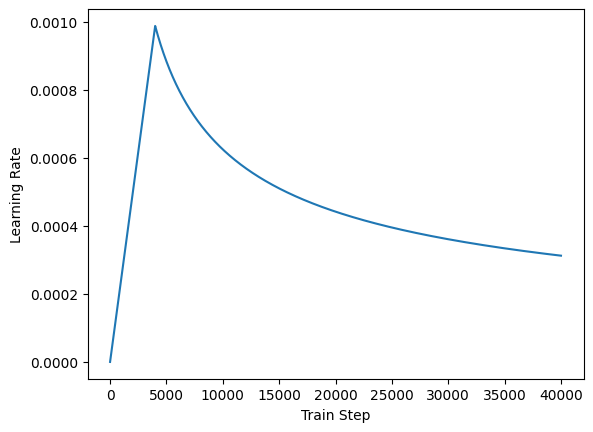

In [ ]:
import matplotlib.pyplot as plt

class Config:
    def __init__(self):
        self.sequence_length = 4
        self.source_vocab_size = 10
        self.target_vocab_size = 10
        self.hidden_size = 4
        self.frequency_factor = 10000
        self.max_position_embeddings = 4
        self.positional_information_type = 'embs'
        self.hidden_dropout_prob = 0.1
        self.num_heads = 2
        self.intermediate_fc_size = self.hidden_size * 4
        self.warmup_steps = 4000


config = Config()

d = 768
lr = LrSchedule()
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

plt.plot(lr(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

### Loss Function

In [ ]:
import tensorflow as tf

def scce_masked_loss(label, pred):
    """
    Computes the masked Sparse Categorical Cross Entropy (SCCE) loss between the predicted and target labels.

    Args:
        label: Target label tensor.
        pred: Predicted logit tensor.

    Returns:
        Masked loss value.
    """
    # Create a mask to ignore padded tokens
    mask = label != 0

    # Use Sparse Categorical Cross Entropy loss with no reduction
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

    # Compute the loss without reducing, which will return a loss value for each token
    loss = loss_object(label, pred)

    # Apply the mask to ignore padded tokens in the loss calculation
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    # Compute the average loss over non-padded tokens
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss

In [ ]:
import tensorflow as tf

def cce_loss(label, pred):
    """
    Computes the Categorical Cross Entropy (CCE) loss with optional label smoothing.

    Args:
        label: Target label tensor.
        pred: Predicted logit tensor.

    Returns:
        Computed CCE loss value.
    """
    # Create a mask to ignore padded tokens
    mask = label != 0

    # Use Categorical Cross Entropy with optional label smoothing
    scc_loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits=True, label_smoothing=0.1, reduction='none')

    # Convert label to one-hot encoding
    label = tf.one_hot(tf.cast(label, tf.int32), config.target_vocab_size)

    # Compute the loss with the label smoothing
    loss = scc_loss(label, pred)

    # Apply the mask to ignore padded tokens in the loss calculation
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    # Compute the average loss over non-padded tokens
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss

### Metrices

In [ ]:
import tensorflow as tf

def masked_accuracy(label, pred):
    """
    Computes the masked accuracy between the predicted and target labels.

    Args:
        label: Target label tensor.
        pred: Predicted label tensor.

    Returns:
        Masked accuracy value.
    """
    # Get the predicted labels by taking the argmax along the last dimension
    pred_labels = tf.argmax(pred, axis=2)

    # Convert the target labels to the same data type as the predicted labels
    label = tf.cast(label, pred_labels.dtype)

    # Compute a binary tensor for matching predicted and target labels
    match = label == pred_labels

    # Create a mask to ignore padded tokens
    mask = label != 0

    # Apply the mask to the matching tensor
    match = match & mask

    # Convert the binary tensor to floating-point values
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)

    # Compute the accuracy over non-padded tokens
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [ ]:
import tensorflow as tf
import numpy as np
from collections import Counter

def compute_precision(candidate_ngrams, reference_ngrams):
    """
    Compute the precision of candidate n-grams with respect to reference n-grams.

    Args:
        candidate_ngrams: List of tuples representing candidate n-grams.
        reference_ngrams: List of tuples representing reference n-grams.

    Returns:
        Precision value.
    """
    candidate_counter = Counter(candidate_ngrams)
    reference_counter = Counter(reference_ngrams)

    # Calculate the intersection of n-grams in candidate and reference sentences
    intersection = sum((candidate_counter & reference_counter).values())

    # Total candidate n-grams
    total_candidate = sum(candidate_counter.values())

    # To avoid division by zero, set precision to a small value if there are no candidate n-grams
    precision = intersection / total_candidate if total_candidate > 0 else 1e-10

    return precision

def compute_bleu_batch(references_batch, candidates_batch, max_n=4):
    """
    Compute the masked BLEU score for a batch of sentences.

    Args:
        label: Target label tensor.
        pred: Predicted tensor.
        max_n: Maximum n-gram for BLEU computation.

    Returns:
        Computed masked BLEU score.
    """

    batch_size = len(references_batch)
    total_bleu_score = 0.0

    # Tokenize and compute n-grams for each candidate-reference pair in the batch
    for i in range(batch_size):
        references = references_batch[i]
        candidates = candidates_batch[i]

        precisions = []

        for candidate, reference in zip(candidates, references):
            candidate_tokens = candidate.split()
            reference_tokens = reference.split()

            # Calculate BLEU score for each n-gram up to max_n
            for n in range(1, max_n + 1):
                candidate_ngrams = [tuple(candidate_tokens[j:j + n]) for j in range(len(candidate_tokens) - n + 1)]
                reference_ngrams = [tuple(reference_tokens[j:j + n]) for j in range(len(reference_tokens) - n + 1)]

                precision_n = compute_precision(candidate_ngrams, reference_ngrams)
                precisions.append(precision_n)

        # Calculate the geometric mean of all the n-gram precisions for this candidate-reference pair
        geometric_mean = np.exp(np.mean(np.log(np.maximum(precisions, 1e-10))))

        # Calculate the brevity penalty for this candidate-reference pair
        reference_length = [len(reference.split()) for reference in references]
        candidate_length = [len(candidate.split()) for candidate in candidates]

        closest_refs = [min(reference_length, key=lambda x: abs(x - candidate_len)) for candidate_len in candidate_length]
        brevity_penalty = np.minimum(np.exp(1 - np.array(closest_refs) / np.array(candidate_length)), 1.0)

        # Calculate the BLEU score for this candidate-reference pair
        bleu_score = geometric_mean * brevity_penalty

        total_bleu_score += bleu_score

    # Calculate the average BLEU score over the entire batch
    average_bleu_score = total_bleu_score / batch_size

    return average_bleu_score

# Example usage with batch of sentences
references_batch = [["the quick brown fox jumped over the lazy dog"]]
candidates_batch = [["the quick brown fox jumped over the lazy dog from space"]]
bleu_score_batch = compute_bleu_batch(references_batch, candidates_batch)
print("Average BLEU Score:", bleu_score_batch)  # Output: 0.78

Average BLEU Score: [0.7860753]


### Callbacks

In [ ]:
import tensorflow as tf

class TransformerCallbacks(tf.keras.callbacks.Callback):
    """
    Custom callback to monitor the validation loss during training and save the best model.

    Args:
        config: Configuration object containing hyperparameters.

    Attributes:
        checkpoint_filepath: Filepath to save the best model.
        patience: Number of epochs to wait for improvement in validation loss.
        best_loss: Best validation loss observed during training.

    Methods:
        on_epoch_end: Called at the end of each epoch to monitor the validation loss.

    """

    def __init__(self, config):
        super(TransformerCallbacks, self).__init__()
        self.checkpoint_filepath = config.checkpoint_filepath
        self.patience = config.patience
        self.best_loss = float('inf')  # Initialize with a very large value for the first comparison

    def on_epoch_end(self, epoch, logs={}):
        """
        Callback function called at the end of each epoch to monitor the validation loss.

        Args:
            epoch: The current epoch number.
            logs: Dictionary containing training and validation metrics.

        """
        # Access the validation loss from the logs dictionary
        val_loss = logs.get('val_loss')

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.model.save(self.checkpoint_filepath)
            print('The best model has been saved at epoch #{}'.format(epoch))
        elif self.patience:
            self.patience -= 1
            if self.patience == 0:
                self.model.stop_training = True
                print('Training stopped. No improvement after {} epochs.'.format(epoch))

### Transformer Configuration

In [ ]:
class Config:
    def __init__(self):
        """
        Configuration class for transformer model hyperparameters.

        Attributes:
            sequence_length: Maximum sequence length for input sequences.
            hidden_size: Hidden size for the transformer model.
            frequency_factor: Frequency factor for positional encodings.
            source_vocab_size: Vocabulary size for the source language.
            target_vocab_size: Vocabulary size for the target language.
            positional_information_type: Type of positional embeddings to use.
            hidden_dropout_prob: Dropout probability for the hidden layers.
            num_heads: Number of attention heads in multi-head attention.
            intermediate_fc_size: Size of the intermediate fully connected layer.
            warmup_steps: Number of warm-up steps for learning rate scheduling.
            num_blocks: Number of encoder and decoder blocks in the transformer.
            final_dropout_prob: Dropout probability for the final output.
            epochs: Number of epochs for training.
            checkpoint_filepath: Filepath for saving model checkpoints.
            patience: Number of epochs with no improvement after which training will be stopped.

        """
        self.sequence_length = 60
        self.hidden_size = 256
        self.frequency_factor = 10000
        self.source_vocab_size = 16721
        self.target_vocab_size = 31405
        self.positional_information_type = 'embs'
        self.hidden_dropout_prob = 0.1
        self.num_heads = 4
        self.intermediate_fc_size = self.hidden_size * 4
        self.warmup_steps = 4000
        self.num_blocks = 2
        self.final_dropout_prob = 0.5
        self.epochs = 30
        self.checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/NMT/tmp/checkpoint'
        self.patience = 3

### Monitor

In [ ]:
import tensorflow as tf

config = Config()

# Create the Transformer model
transformer = Transformer(config, config.source_vocab_size, config.target_vocab_size)

# Create the learning rate schedule
lr = LrSchedule(config.hidden_size, config.warmup_steps)

# Create the custom callbacks for monitoring and early stopping
callbacks = TransformerCallbacks(config)

# Create the Adam optimizer with the custom learning rate
optimizer = tf.keras.optimizers.Adam(
    lr,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

# Compile the Transformer model with the custom loss function and optimizer
transformer.compile(
    loss=cce_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy]
)

# Train the Transformer model on the training dataset
# and validate it on the validation dataset
history = transformer.fit(
    train_ds,
    epochs=config.epochs,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/30
1828/1828 [==============================] - ETA: 0s - loss: 6.0016 - masked_accuracy: 0.3204

The best model has been saved at epoch #0
1828/1828 [==============================] - 536s 266ms/step - loss: 6.0016 - masked_accuracy: 0.3204 - val_loss: 4.3211 - val_masked_accuracy: 0.4816
Epoch 2/30
 972/1828 [==============>...............] - ETA: 2:43 - loss: 4.3010 - masked_accuracy: 0.5027

## Inference

In [ ]:
config = Config()

with open("vectorize.pickle", "rb") as fp:
    data = pickle.load(fp)

test_pairs = data["test"]
eng_vectorizer = tf.keras.layers.TextVectorization.from_config(data["engvec_config"])
eng_vectorizer.set_weights(data["engvec_weights"])
fra_vectorizer = tf.keras.layers.TextVectorization.from_config(data["fravec_config"])
fra_vectorizer.set_weights(data["fravec_weights"])

# Load the trained model
custom_objects = {
    "LrSchedule": LrSchedule,
    "PositionalEmbeddings": PositionalEmbeddings,
    "Embeddings": Embeddings,
    "AttentionHead": AttentionHead,
    "MultiHead_Attention": MultiHead_Attention,
    "FeedForward": FeedForward,
    "Encoder": Encoder,
    "Decoder": Decoder,
    "Transformer": Transformer,
    "cce_loss": cce_loss,
    "masked_accuracy": masked_accuracy}

with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/NMT/tmp/checkpoint')

def translate(sentence, sequence_length, target_vocab_size):
    """
    Generate the translated sentence using the trained Transformer model.

    Args:
        sentence (str): The input English sentence to be translated.
        sequence_length (int): Maximum sequence length for input sequences.
        target_vocab_size (int): Vocabulary size for the target language.

    Returns:
        list: A list containing the translated words in the target language.

    """
    enc_tokens = eng_vectorizer([sentence])
    lookup = list(fra_vectorizer.get_vocabulary())
    start_sentinel, end_sentinel = "[start]", "[end]"
    output_sentence = [start_sentinel]

    # Generate the translated sentence word by word
    for i in range(sequence_length):
        vector = fra_vectorizer([" ".join(output_sentence)])
        assert vector.shape == (1, sequence_length + 1)
        dec_tokens = vector[:, :-1]
        assert dec_tokens.shape == (1, sequence_length)
        pred = model({"encoder_inputs": enc_tokens, "decoder_inputs": dec_tokens}, training=False)
        assert pred.shape == (1, sequence_length, target_vocab_size)
        word = lookup[np.argmax(pred[0, i, :])]
        output_sentence.append(word)
        if word == end_sentinel:
            break

    return output_sentence

In [ ]:
test_count = 3
for n in range(test_count):
    english_sentence, french_sentence = random.choice(test_pairs)
    translated = translate(english_sentence)
    print(f"Test {n}:")
    print(f"Source sentence:{english_sentence}")
    print(f"Typical translation: {french_sentence}")
    print(f"Model translation {' '.join(translated)}")
    print()

Test 0:
What did you go there for ?
== [start] Pour quelle raison y as-tu été  ?  [end]
-> [start] [end]

Test 1:
That bicycle is too small for you .
== [start] Ce vélo est trop petit pour vous . [end]
-> [start] [end]

Test 2:
Are you mentally ill ?
== [start] Êtes-vous mentalement dérangé  ?  [end]
-> [start] [end]

